In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports
#the problem is too simple to be run on GPU. Seriously.
%env THEANO_FLAGS='device=cpu'
import theano
import theano.tensor as T
floatX = theano.config.floatX

import lasagne


env: THEANO_FLAGS='device=cpu'


In [2]:
%load_ext autoreload
%autoreload 2

# This tutorial explains the basic pipline of Agentnet experiment
* experiment setup
* designing agent
* interacting with environment
* computing losses
* training

# Experiment setup
* Here we load a simple experiment environment (description below)
* Designing one from scratch is explained in later tutorials

In [3]:
import agentnet.experiments.boolean_reasoning as experiment
print experiment.__doc__


This is a dummy experiment setup that requires agent to make advantage of
a simple logical formula in order to maximize expected reward.

The world agent exists in has a number of boolean hidden factors:
X1~3, Y1, Y2.

The factors are not independent. Namely,
 - Y1 = (not X1) and X2
 - Y2 = not Y1

In the initial moment of time, agent knows nothing about any of them.
At each turn, agent may decide to
 - "open" one of the hidden factors.
   - if the factor turns out to be 1, agent receives +1 reward for X*, +3 for Y*
   - Otherwise, the reward equals -1 for X*, -3 for Y*
   - checking a single factor more than once a session will result in -0.5 reward for every attempt but for first one
 - decide to quit session
   - yields reward of 0 and ends the interaction.
   - all farther actions will have no effect until next session

It is expected, that in order to maximize it's expected reward, the agent
will converge to a strategy of polling X for as long as they yield information
on Y, and 

In [4]:
#Create an environment with all default parameters
env = experiment.BooleanReasoningEnvironment()

# agent setup
* An agent implementation has to contain three parts:
 * Memory layer(s)
  * in this case, a single one-step GRU
 * Q-values evaluation layers
  * in this case, a lasagne dense layer based on memory layer
 * Resolver - acton picker layer
  * in this case, the resolver has epsilon-greedy policy

In [5]:
from agentnet.resolver import EpsilonGreedyResolver
from agentnet.memory import GRUMemoryLayer
from agentnet.agent import Agent

In [6]:
import lasagne

#only 10 hidden neurons
n_hid=10


_observation_layer = lasagne.layers.InputLayer([None,env.observation_size],name="obs_input")
_prev_state_layer = lasagne.layers.InputLayer([None,n_hid],name="prev_state_input")

#memory
#note that this isn't the same as lasagne recurrent units (see next text tab for detail)
gru = GRUMemoryLayer(n_hid,
                     _observation_layer,
                     _prev_state_layer,
                     name="gru0")

#q_eval
q_eval = lasagne.layers.DenseLayer(gru,num_units = env.n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,name="QEvaluator")

#resolver
epsilon = theano.shared(np.float32(0.1),name="e-greedy.epsilon")

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")


#all together
agent = Agent(_observation_layer,
              {gru:_prev_state_layer},
              q_eval,resolver)


In [7]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[gru0.W_in_to_updategate,
 gru0.W_hid_to_updategate,
 gru0.b_updategate,
 gru0.W_in_to_resetgate,
 gru0.W_hid_to_resetgate,
 gru0.b_resetgate,
 gru0.W_in_to_hidden_update,
 gru0.W_hid_to_hidden_update,
 gru0.b_hidden_update,
 QEvaluator.W,
 QEvaluator.b]

## Agent setup in detail
* __Memory layers__
 * One-step recurrent layer
     * takes input and one's previous state
     * returns new memory state
   * Can be arbitrary lasagne layer
   * Several one-step recurrent units are implemented in __agentnet.memory__
   * Note that lasagne's default recurrent networks roll for several steps at once
     * in other words, __using lasagne recurrent units as memory means recurrence inside recurrence__
 * Using more than one memory layer is explained in farther tutorials


* __Q-values evaluation layer__
 * Can be arbitrary lasagne network
 * returns predicted Q-values for each action
 * Usually depends on memory as an input


* __Resolver__ - action picker
 * Decides on what action is taken
 * Normally takes Q-values as input
 * Currently all experiments require integer output
 * Several resolver layers are implemented in __agentnet.resolver__

# Interacting with environment
* an agent has a method that produces symbolic environment interaction sessions
* Such sessions are represented as tensors with dimensions matching pattern [batch_session_i, time_tick, ...]
* interactions result in sequences of observations, actions, q-values,etc
* one has to pre-define maximum session length.
 * in this case, environment implements an indicator of whether session has ended by current tick
* Since this environment also implements Objective methods, it can evaluate rewards for each [batch, time_tick]


In [8]:
#produce interaction sequences of length <= 10
state_seq,observation_seq,agent_state,action_seq,qvalues_seq = agent.get_sessions(
    env,
    session_length=10,
    batch_size=env.batch_size,
)


hidden_seq = agent_state[gru]

#get rewards for all actions
rewards_seq = env.get_reward_sequences(state_seq,action_seq)

#get indicator whether session is still active
is_alive_seq = env.get_whether_alive(observation_seq)


# Evaluating loss function
* In this case, we want to 
 * first get pairs of (predicted Qvalue, reference Qvalue) for all actions commited
 * second, define loss function
 * third, compute grad and update weights

#### Define loss functions

In [9]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import qlearning


#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = theano.shared(np.float32(0.95),name = 'q_learning_gamma')


squarred_Qerror = qlearning.get_elementwise_objective(
    qvalues_seq,
    action_seq,
    rewards_seq,
    is_alive_seq,
    gamma_or_gammas=gamma,)


mse_Qloss = squarred_Qerror.sum(axis = 1).mean()

In [10]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-3

In [11]:
loss = mse_Qloss + reg_l2

#### Compute weight updates

In [12]:
updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.1)

#### Some auxilary evaluation metrics

In [13]:
mean_session_reward = rewards_seq.sum(axis=1).mean()
#...

# Compile train and evaluation functions

In [14]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)

evaluation_fun = theano.function([],[loss,mse_Qloss,reg_l2,mean_session_reward])

# session visualization tools


* this is a completely optional step of visualizing agent's sessions as chains of actions
* usually useful to get insight on what worked and what din't
* in this case, we print strings following pattern
  * [action_name] ([predicted action qvalue]) -> reward [reference qvalue] | next iteration

* plot shows
    * time ticks over X, abstract values over Y
    * bold lines are Qvalues for actions
    * dots on bold lines represent what actions were taken at each moment of time
    * dashed lines are agent's hidden state neurons
    * blue vertical line - session end
    
    
__Warning! the visualization tools are underdeveloped and only allow simple operations.__

if you found yourself struggling to make it do what you want for 5 minutes, go write your own tool [and contribute it :)]


In [15]:
from agentnet.display.sessions import print_sessions
get_printables = theano.function([], [
        hidden_seq,qvalues_seq, action_seq,rewards_seq,is_alive_seq
    ])

def display_sessions(with_plots = False):
        
    hidden_log,qvalues_log,actions_log,reward_log, is_alive_log = get_printables()
    
    
    print_sessions(qvalues_log,actions_log,reward_log,
                   is_alive_seq = is_alive_log,
                   hidden_seq=hidden_log,
                   action_names=env.feature_names,
                  
                  plot_policy = with_plots)

session # 0
 X1(qv = 0.0) -> 1.0 |  X2(qv = 0.0871255621314) -> -1.0 |  X2(qv = 0.0915364697576) -> -0.5 |  X2(qv = 0.103280372918) -> -0.5 |  X2(qv = 0.115901403129) -> -0.5 |  X2(qv = 0.126715153456) -> -0.5 |  X3(qv = -0.0893890708685) -> 1.0 |  X2(qv = 0.149639233947) -> -0.5 |  Y2(qv = -0.0949992164969) -> 3.0 | 



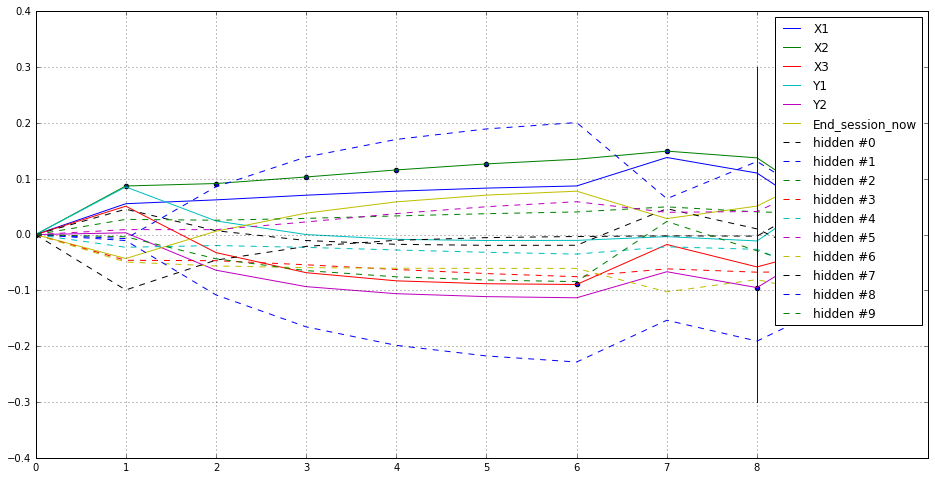

In [16]:
#visualize untrained network performance (which is mostly random)
env.generate_new_data_batch(1)
display_sessions(with_plots=True)

# Training loop

In [17]:
from agentnet.display import Metrics
score_log = Metrics()

In [18]:
#starting epoch
epoch_counter = 1

#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

epoch 100,loss 9.00827, epsilon 0.96275, rewards: ( e-greedy -0.09500, greedy 0.18000) 
rec 8.996 reg 0.012
epoch 200,loss 10.29848, epsilon 0.92696, rewards: ( e-greedy -0.15550, greedy 0.40200) 
rec 10.286 reg 0.012
epoch 300,loss 9.22666, epsilon 0.89257, rewards: ( e-greedy -0.17995, greedy 0.49180) 
rec 9.214 reg 0.012
epoch 400,loss 13.13453, epsilon 0.85954, rewards: ( e-greedy -0.26195, greedy 0.57262) 
rec 13.122 reg 0.012
epoch 500,loss 7.24309, epsilon 0.82779, rewards: ( e-greedy -0.27076, greedy 0.70536) 
rec 7.230 reg 0.013
epoch 600,loss 10.34974, epsilon 0.79730, rewards: ( e-greedy -0.30368, greedy 0.81482) 
rec 10.336 reg 0.013
epoch 700,loss 14.04711, epsilon 0.76799, rewards: ( e-greedy -0.34332, greedy 0.64334) 
rec 14.033 reg 0.014
epoch 800,loss 9.40531, epsilon 0.73984, rewards: ( e-greedy -0.23398, greedy 0.81401) 
rec 9.391 reg 0.014
epoch 900,loss 6.54378, epsilon 0.71279, rewards: ( e-greedy -0.12559, greedy 1.03261) 
rec 6.528 reg 0.015
epoch 1000,loss 9.19

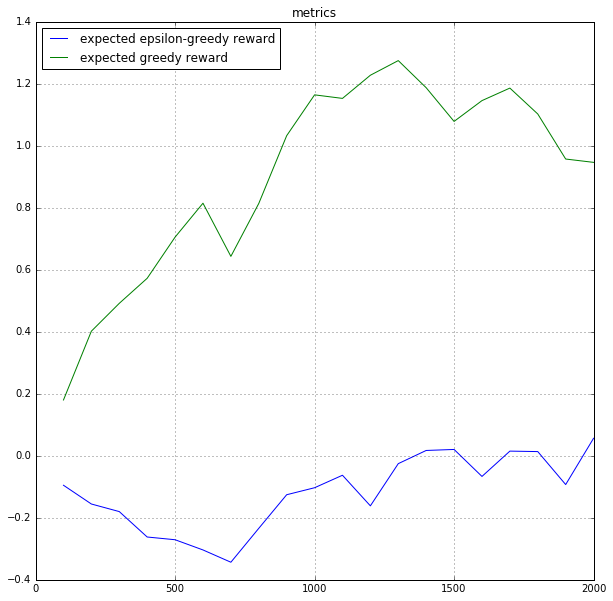

Random session examples
session # 0
 Y2(qv = 1.16342878342) -> 3.0 |  X2(qv = 0.0411659777164) -> -1.0 | 



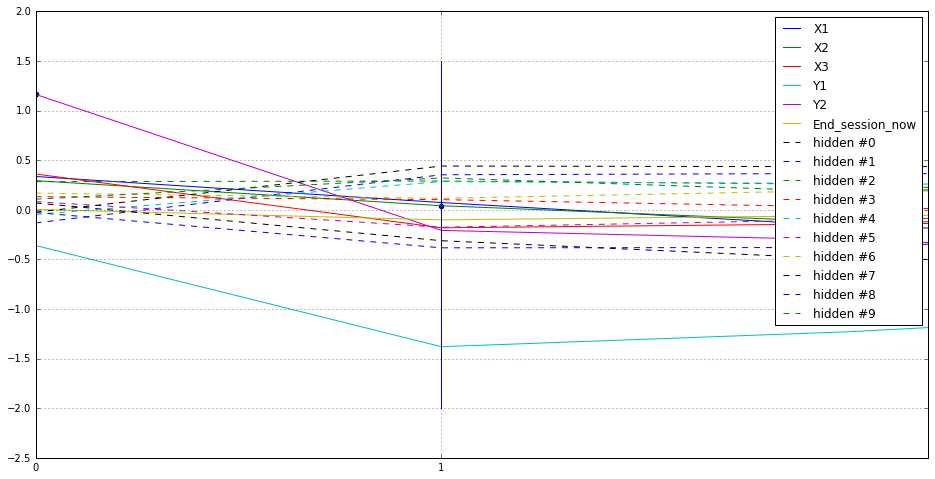

session # 1
 X1(qv = 0.335812330246) -> 1.0 |  X2(qv = 0.199112161994) -> -1.0 |  Y2(qv = 0.903477668762) -> 3.0 | 



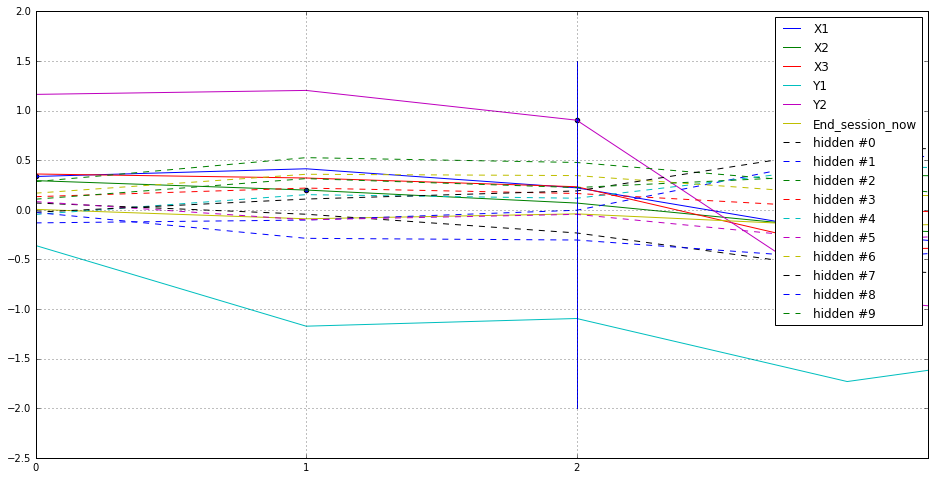

session # 2
 X3(qv = 0.361047148705) -> -1.0 |  X2(qv = 0.343026697636) -> -1.0 |  Y2(qv = 1.52108049393) -> 3.0 | 



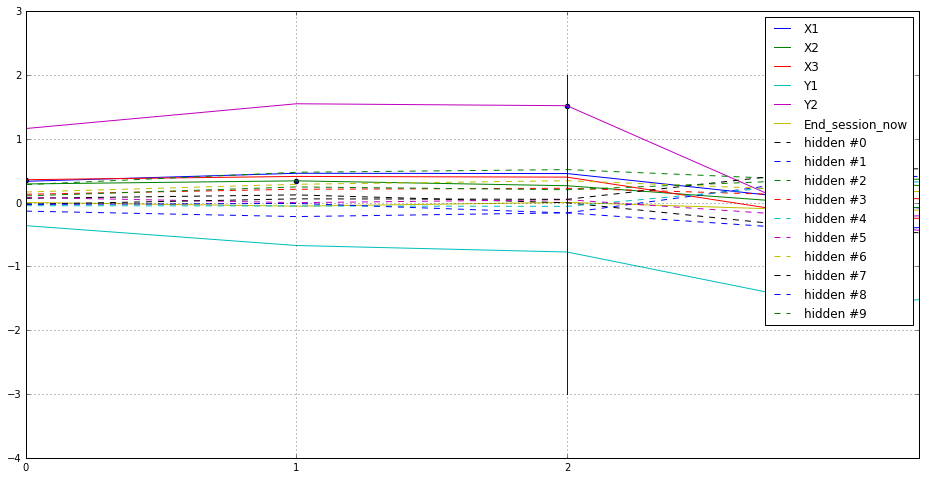

epoch 2100,loss 7.85260, epsilon 0.46012, rewards: ( e-greedy 0.19586, greedy 1.08693) 
rec 7.826 reg 0.027
epoch 2200,loss 7.03316, epsilon 0.44404, rewards: ( e-greedy 0.28628, greedy 1.21823) 
rec 7.005 reg 0.028
epoch 2300,loss 5.57199, epsilon 0.42859, rewards: ( e-greedy 0.43765, greedy 1.40141) 
rec 5.543 reg 0.029
epoch 2400,loss 9.07380, epsilon 0.41375, rewards: ( e-greedy 0.33888, greedy 1.34627) 
rec 9.045 reg 0.029
epoch 2500,loss 3.99194, epsilon 0.39949, rewards: ( e-greedy 0.38999, greedy 1.43164) 
rec 3.962 reg 0.030
epoch 2600,loss 9.65693, epsilon 0.38578, rewards: ( e-greedy 0.38600, greedy 1.27348) 
rec 9.626 reg 0.031
epoch 2700,loss 11.54636, epsilon 0.37262, rewards: ( e-greedy 0.30740, greedy 1.13613) 
rec 11.515 reg 0.031
epoch 2800,loss 8.63218, epsilon 0.35997, rewards: ( e-greedy 0.31166, greedy 1.16252) 
rec 8.600 reg 0.032
epoch 2900,loss 6.77552, epsilon 0.34781, rewards: ( e-greedy 0.35049, greedy 1.27627) 
rec 6.743 reg 0.032
epoch 3000,loss 5.93633, e

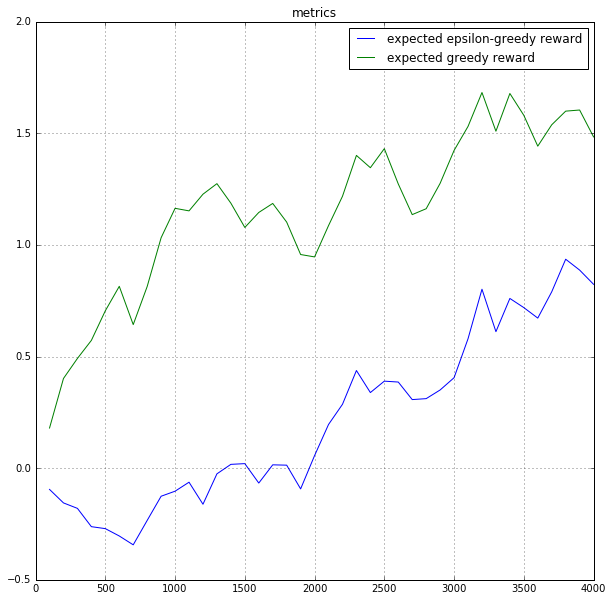

Random session examples
session # 0
 Y2(qv = 1.77219367027) -> 3.0 |  X1(qv = 0.231599926949) -> 1.0 | 



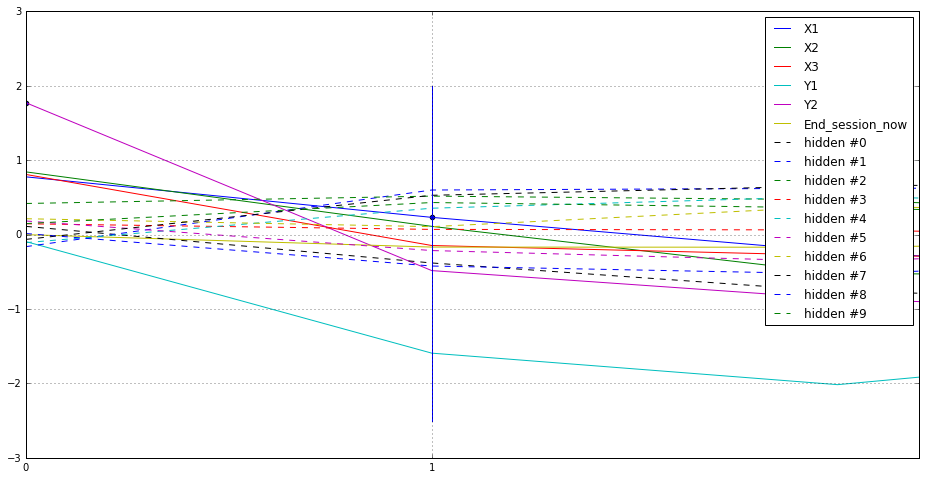

session # 1
 X1(qv = 0.776114940643) -> -1.0 |  Y2(qv = 2.20025968552) -> 3.0 |  X1(qv = 0.139655306935) -> -0.5 |  X3(qv = -0.152697384357) -> 1.0 | 



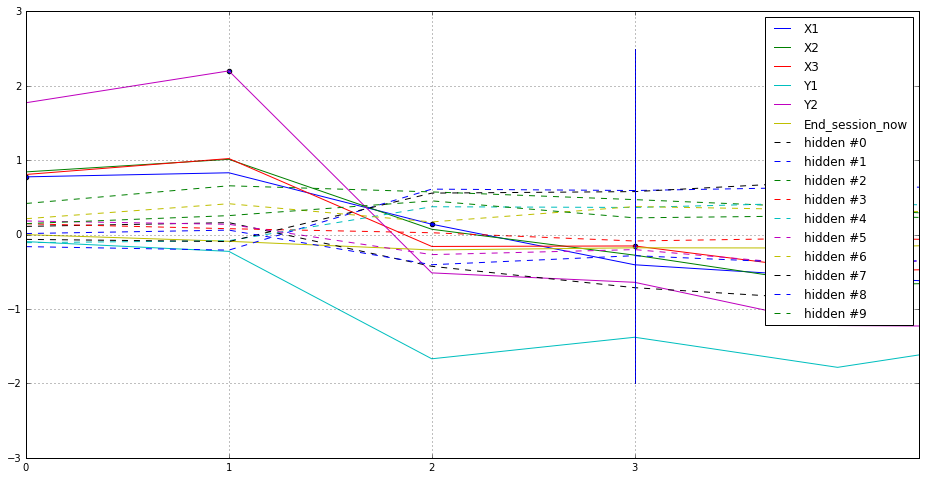

session # 2
 Y2(qv = 1.77219367027) -> 3.0 |  X1(qv = 0.231599912047) -> 1.0 | 



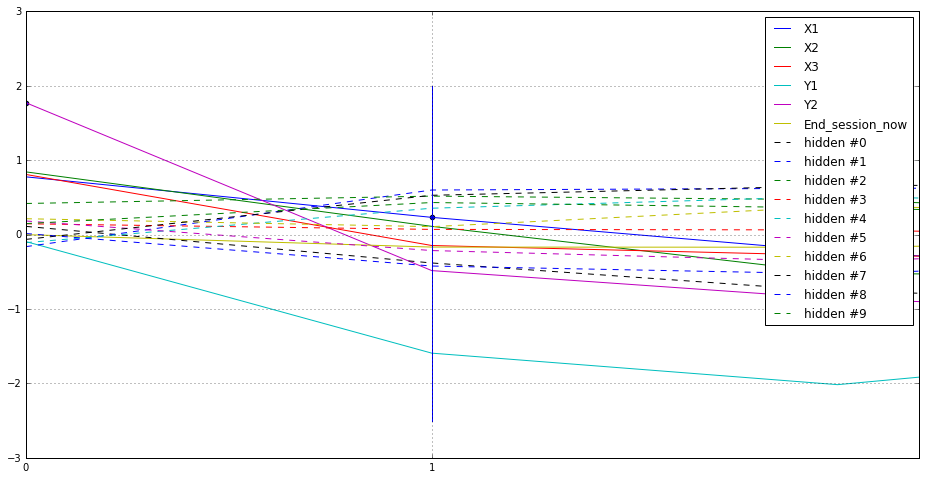

epoch 4100,loss 6.45682, epsilon 0.23428, rewards: ( e-greedy 0.90148, greedy 1.56585) 
rec 6.418 reg 0.039
epoch 4200,loss 4.07531, epsilon 0.22706, rewards: ( e-greedy 1.10133, greedy 1.69926) 
rec 4.036 reg 0.040
epoch 4300,loss 6.23074, epsilon 0.22011, rewards: ( e-greedy 1.00620, greedy 1.71934) 
rec 6.191 reg 0.040
epoch 4400,loss 6.77573, epsilon 0.21344, rewards: ( e-greedy 1.08058, greedy 1.76740) 
rec 6.735 reg 0.040
epoch 4500,loss 10.51086, epsilon 0.20703, rewards: ( e-greedy 1.08752, greedy 1.75066) 
rec 10.470 reg 0.041
epoch 4600,loss 10.88779, epsilon 0.20088, rewards: ( e-greedy 0.90377, greedy 1.57060) 
rec 10.846 reg 0.041
epoch 4700,loss 7.29188, epsilon 0.19496, rewards: ( e-greedy 0.97339, greedy 1.55354) 
rec 7.250 reg 0.042
epoch 4800,loss 9.24184, epsilon 0.18928, rewards: ( e-greedy 0.96605, greedy 1.60818) 
rec 9.199 reg 0.043
epoch 4900,loss 12.37626, epsilon 0.18382, rewards: ( e-greedy 0.96945, greedy 1.54737) 
rec 12.333 reg 0.043
epoch 5000,loss 8.0166

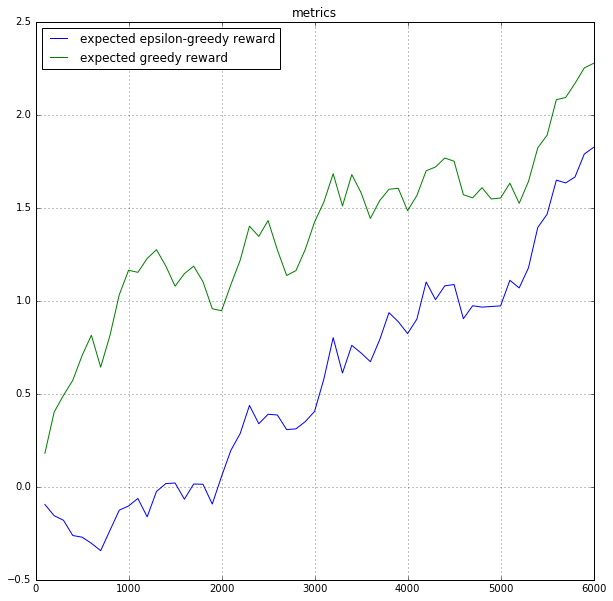

Random session examples
session # 0
 Y2(qv = 2.12675333023) -> 3.0 |  X2(qv = 0.349239706993) -> 1.0 | 



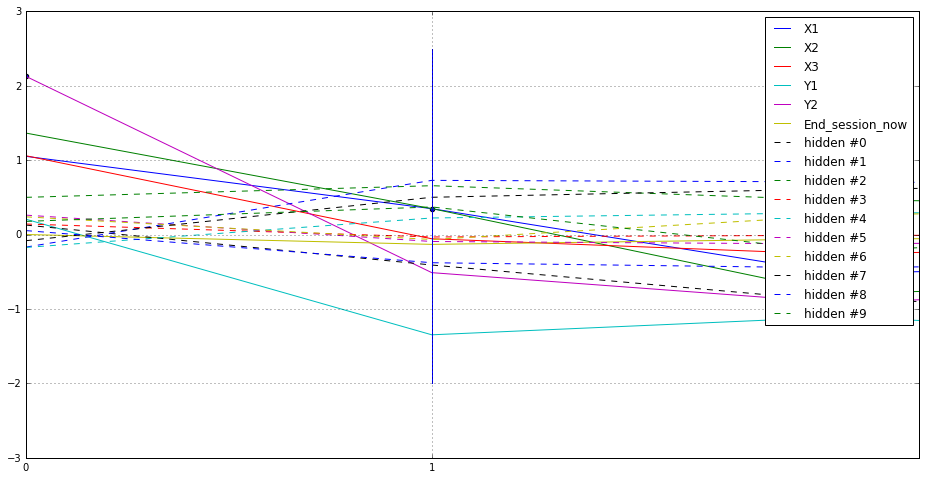

session # 1
 Y2(qv = 2.12675333023) -> 3.0 |  X2(qv = 0.349239706993) -> -1.0 | 



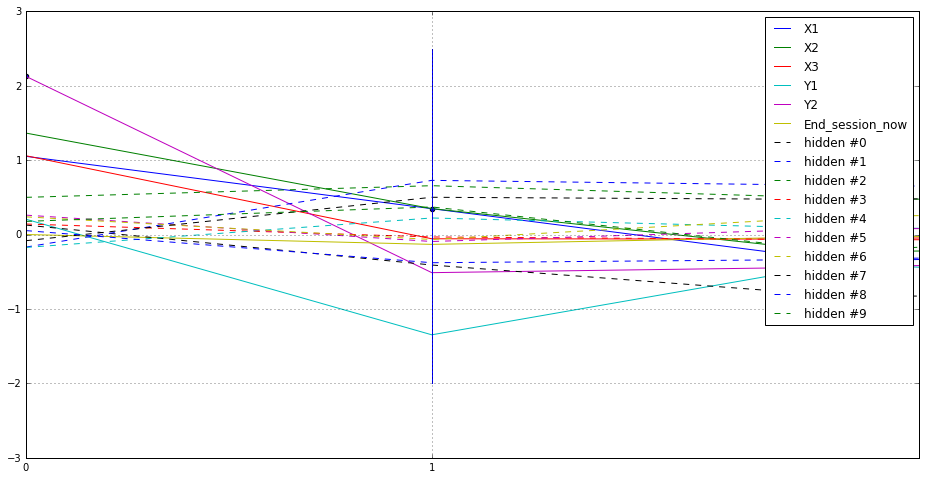

session # 2
 X2(qv = 1.36449146271) -> 1.0 |  Y2(qv = 1.53742396832) -> 3.0 |  X1(qv = 0.125141739845) -> 1.0 |  X1(qv = -0.241234719753) -> -0.5 | 



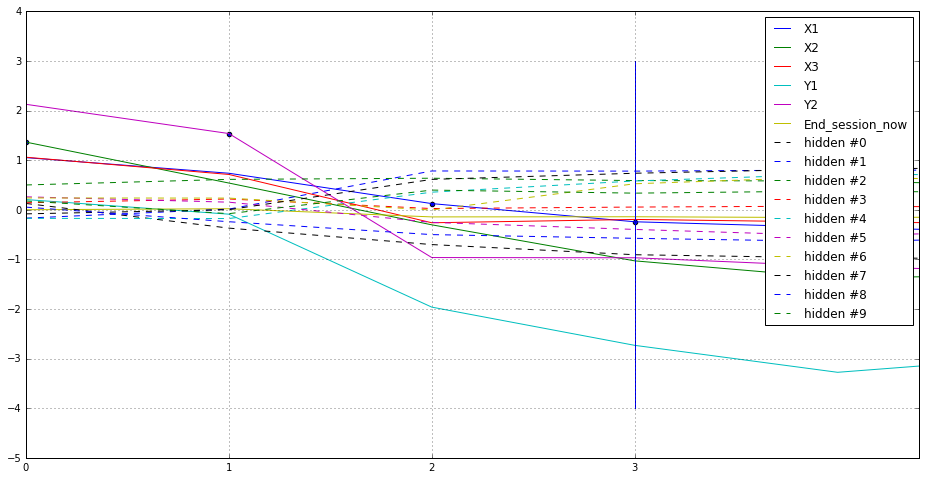

epoch 6100,loss 5.95405, epsilon 0.13280, rewards: ( e-greedy 1.74246, greedy 2.24907) 
rec 5.891 reg 0.063
epoch 6200,loss 6.26997, epsilon 0.12956, rewards: ( e-greedy 1.74321, greedy 2.24416) 
rec 6.205 reg 0.065
epoch 6300,loss 5.76419, epsilon 0.12644, rewards: ( e-greedy 1.74389, greedy 2.23475) 
rec 5.697 reg 0.067
epoch 6400,loss 4.36026, epsilon 0.12344, rewards: ( e-greedy 1.81450, greedy 2.29127) 
rec 4.292 reg 0.069
epoch 6500,loss 5.46183, epsilon 0.12056, rewards: ( e-greedy 1.83805, greedy 2.28715) 
rec 5.392 reg 0.070
epoch 6600,loss 3.97389, epsilon 0.11779, rewards: ( e-greedy 1.96924, greedy 2.37843) 
rec 3.902 reg 0.072
epoch 6700,loss 3.30874, epsilon 0.11513, rewards: ( e-greedy 1.99732, greedy 2.42059) 
rec 3.236 reg 0.073
epoch 6800,loss 4.71125, epsilon 0.11258, rewards: ( e-greedy 1.97259, greedy 2.39853) 
rec 4.637 reg 0.074
epoch 6900,loss 3.23159, epsilon 0.11013, rewards: ( e-greedy 2.03533, greedy 2.47868) 
rec 3.157 reg 0.075
epoch 7000,loss 3.46945, eps

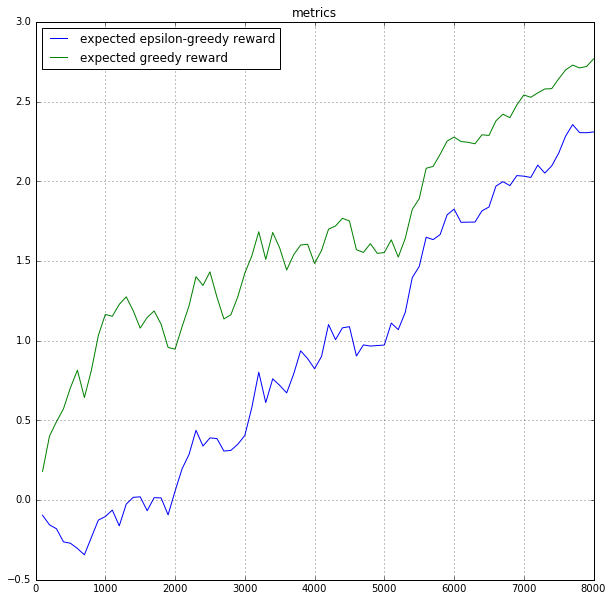

Random session examples
session # 0
 Y1(qv = 0.366966247559) -> 3.0 |  Y2(qv = 1.11377334595) -> -3.0 |  X2(qv = 0.987339615822) -> 1.0 | 



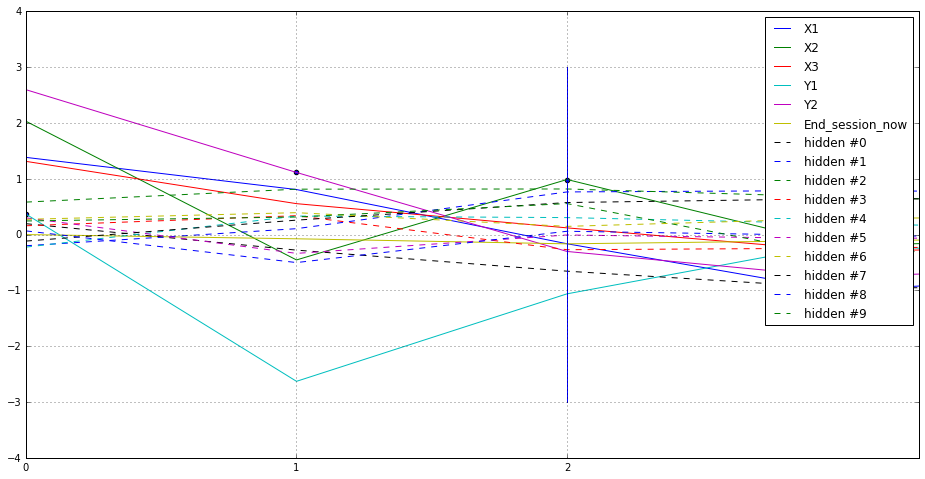

session # 1
 Y2(qv = 2.59696769714) -> -3.0 |  X2(qv = 3.7555911541) -> 1.0 |  Y1(qv = 3.02107787132) -> 3.0 |  X1(qv = -0.781755685806) -> -1.0 |  X3(qv = -0.0721898376942) -> 1.0 | 



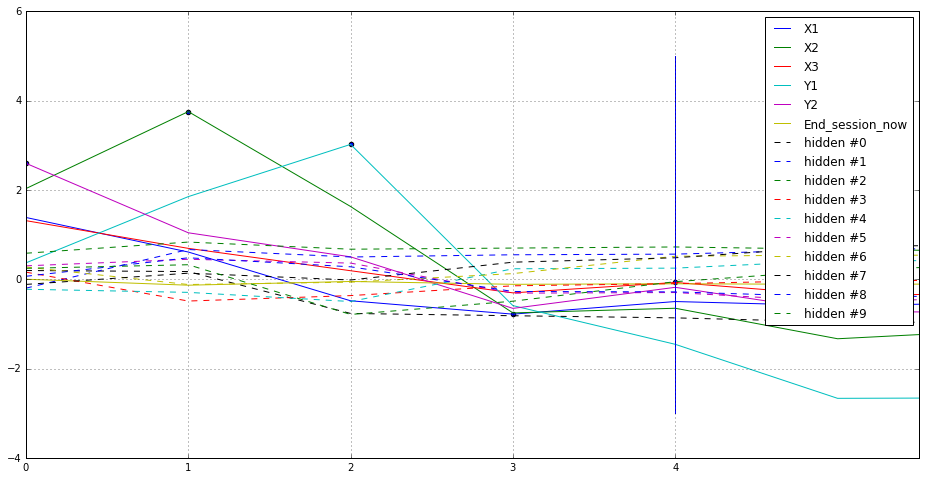

session # 2
 Y2(qv = 2.59696769714) -> 3.0 |  X1(qv = 0.321523457766) -> -1.0 |  X3(qv = 0.0795873403549) -> -1.0 | 



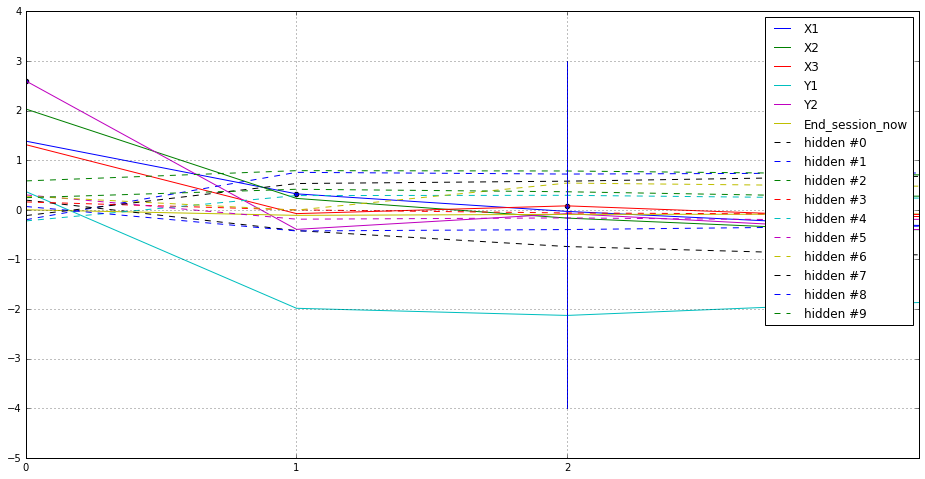

epoch 8100,loss 5.45503, epsilon 0.08721, rewards: ( e-greedy 2.27304, greedy 2.73092) 
rec 5.377 reg 0.078
epoch 8200,loss 2.56591, epsilon 0.08575, rewards: ( e-greedy 2.35574, greedy 2.77783) 
rec 2.488 reg 0.078
epoch 8300,loss 2.59634, epsilon 0.08435, rewards: ( e-greedy 2.35516, greedy 2.80005) 
rec 2.518 reg 0.078
epoch 8400,loss 3.06704, epsilon 0.08300, rewards: ( e-greedy 2.28965, greedy 2.72004) 
rec 2.988 reg 0.079
epoch 8500,loss 2.81640, epsilon 0.08170, rewards: ( e-greedy 2.31068, greedy 2.68804) 
rec 2.738 reg 0.079
epoch 8600,loss 4.11373, epsilon 0.08046, rewards: ( e-greedy 2.23461, greedy 2.65924) 
rec 4.035 reg 0.079
epoch 8700,loss 2.31478, epsilon 0.07927, rewards: ( e-greedy 2.35615, greedy 2.72831) 
rec 2.236 reg 0.078
epoch 8800,loss 2.45980, epsilon 0.07812, rewards: ( e-greedy 2.35054, greedy 2.73548) 
rec 2.381 reg 0.079
epoch 8900,loss 2.56528, epsilon 0.07702, rewards: ( e-greedy 2.32048, greedy 2.74193) 
rec 2.487 reg 0.079
epoch 9000,loss 2.38958, eps

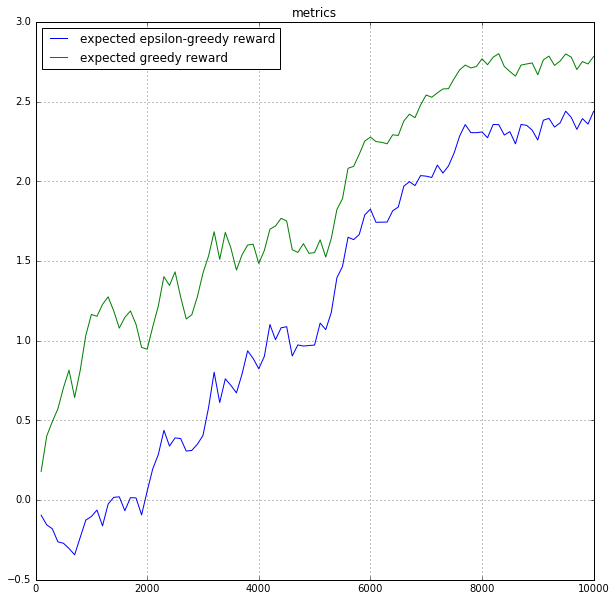

Random session examples
session # 0
 Y2(qv = 2.61072516441) -> -3.0 |  X2(qv = 3.76779222488) -> 1.0 |  Y1(qv = 2.99306082726) -> 3.0 | 



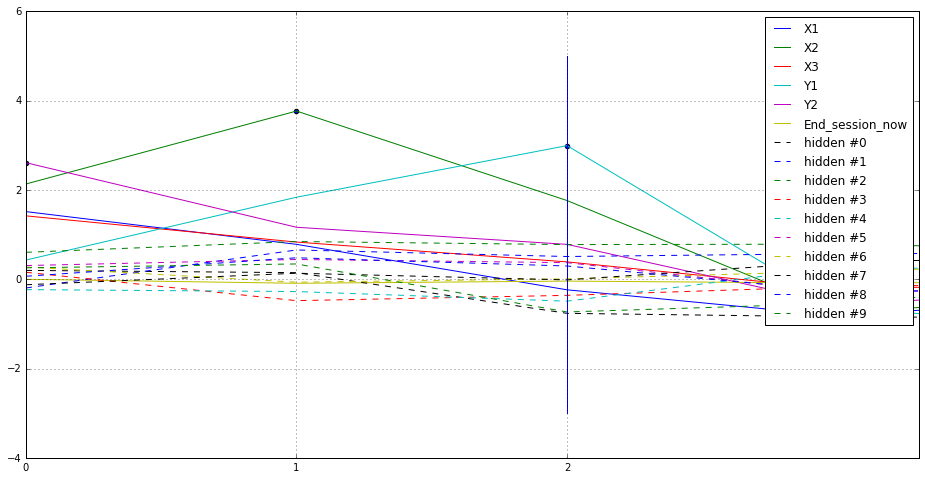

session # 1
 Y2(qv = 2.61072516441) -> -3.0 |  X2(qv = 3.76779222488) -> 1.0 |  Y1(qv = 2.99306082726) -> 3.0 | 



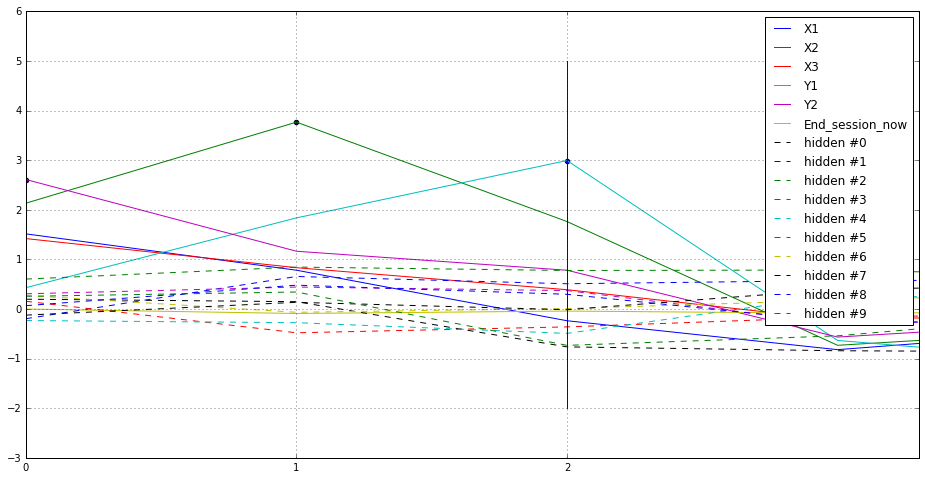

session # 2
 Y2(qv = 2.61072516441) -> 3.0 |  X1(qv = 0.309026747942) -> 1.0 |  X3(qv = -0.0286547541618) -> -1.0 | 



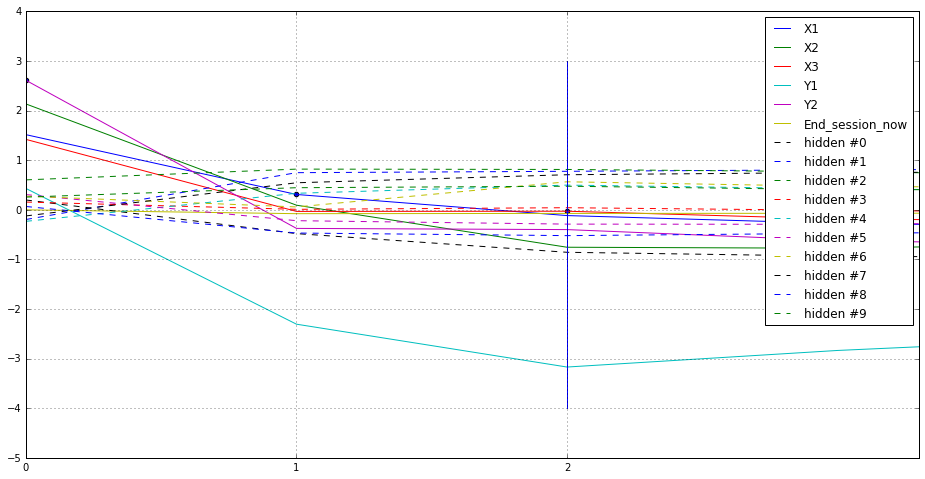

In [19]:
n_epochs = 10000
batch_size=10

for i in range(n_epochs):    
    
    #train
    env.generate_new_data_batch(batch_size)
    loss,avg_reward = train_fun()
    
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%10 ==0:
        current_epsilon =  0.05 + 0.95*np.exp(-epoch_counter/2500.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##show current learning progress
    if epoch_counter%100 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected epsilon-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))

        print "epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,l2_penalty)

        
    #visualize learning curve and sample sessions
    if epoch_counter %2000 ==0:
        print "Learning curves:"
        score_log.plot()
        
        print "Random session examples"
        env.generate_new_data_batch(3)
        display_sessions(with_plots=True)



        
        
    epoch_counter  +=1


# Evaluate results

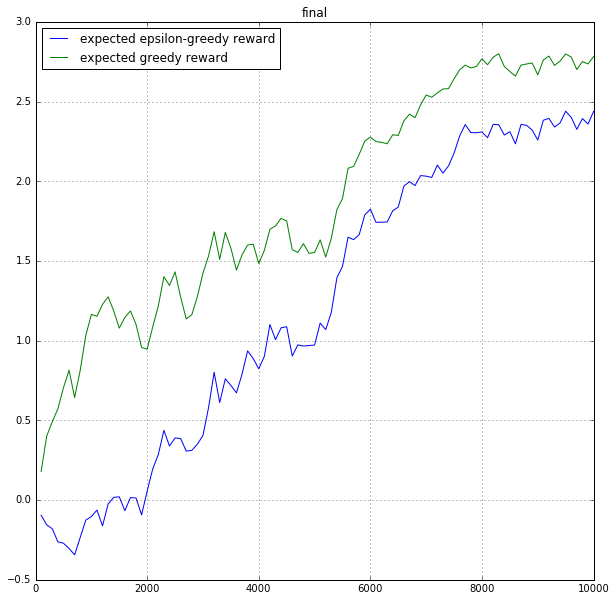

In [20]:
score_log.plot("final")

Random session examples
session # 0
 Y2(qv = 2.61072516441) -> 3.0 |  X1(qv = 0.309026807547) -> -1.0 |  X3(qv = 0.0662711262703) -> -1.0 | 



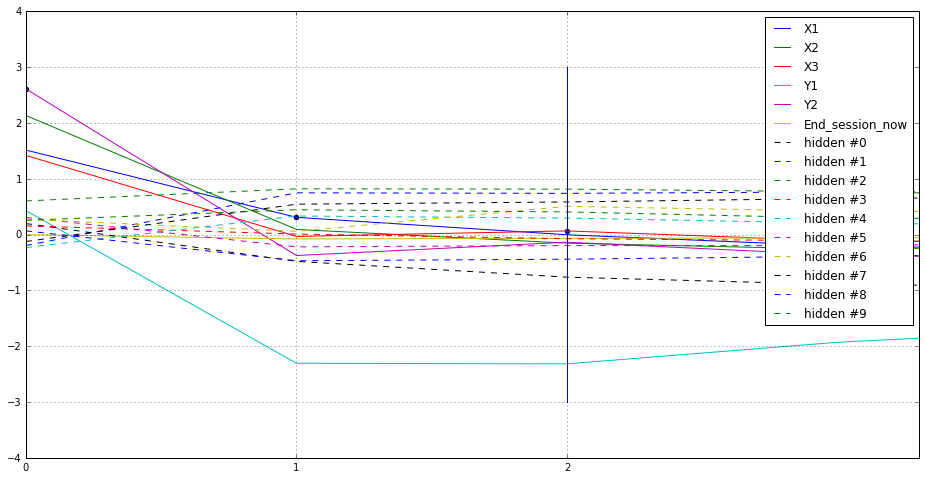

session # 1
 Y2(qv = 2.61072516441) -> -3.0 |  X2(qv = 3.7677924633) -> 1.0 |  Y1(qv = 2.99306058884) -> 3.0 | 



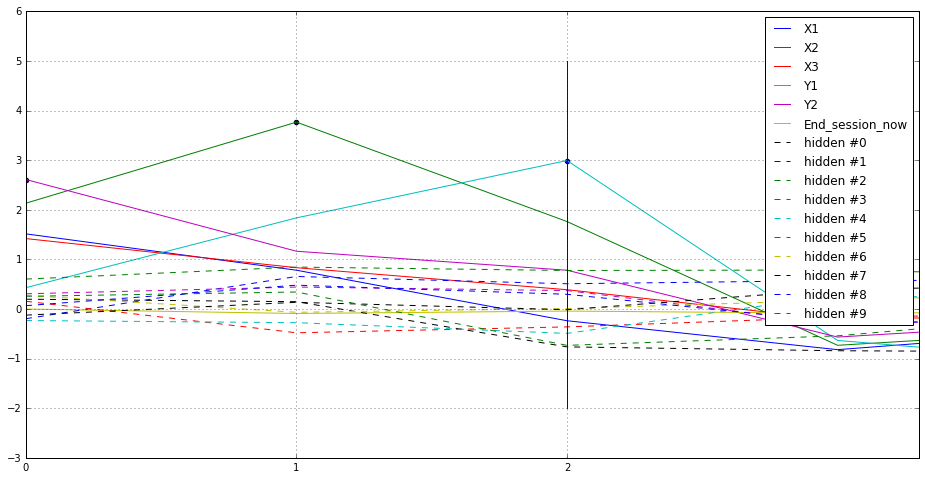

session # 2
 Y2(qv = 2.61072516441) -> 3.0 |  X1(qv = 0.309026807547) -> 1.0 |  X3(qv = -0.0286547541618) -> 1.0 | 



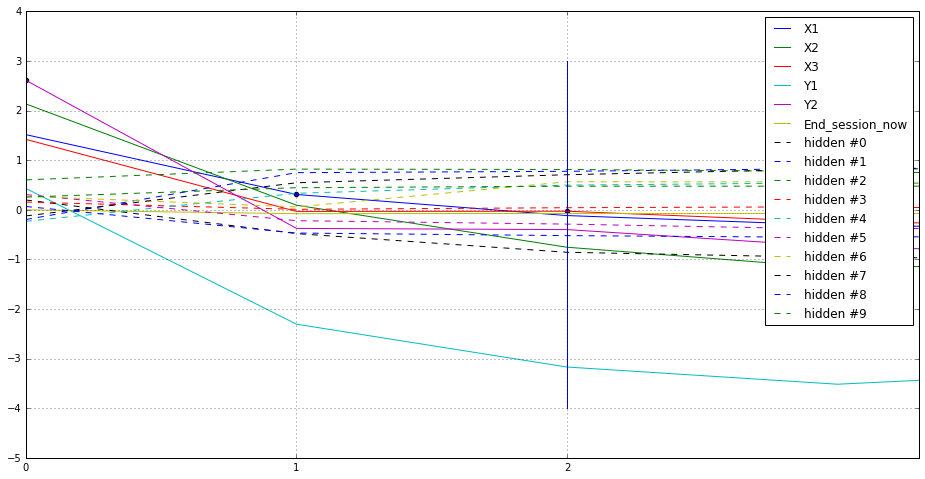

session # 3
 Y2(qv = 2.61072516441) -> 3.0 |  X1(qv = 0.309026807547) -> 1.0 |  X3(qv = -0.0286547541618) -> -1.0 | 



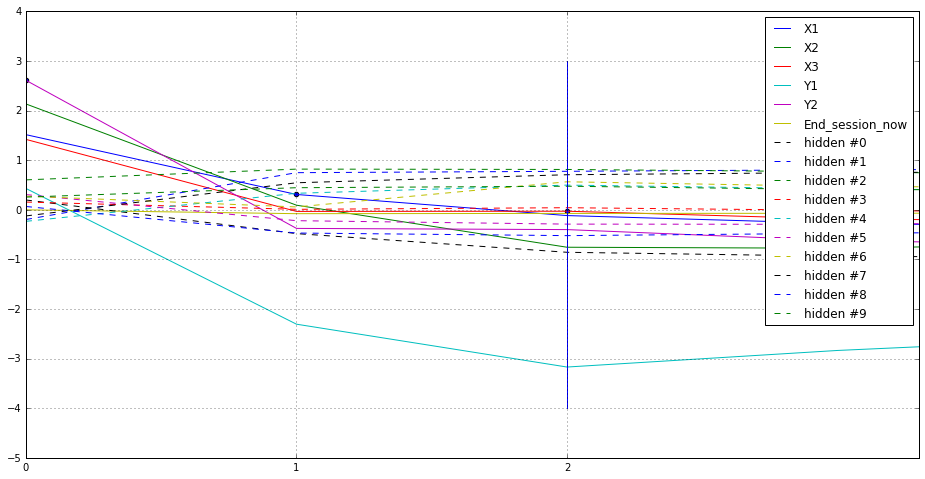

session # 4
 Y2(qv = 2.61072516441) -> 3.0 |  X1(qv = 0.309026807547) -> 1.0 |  X3(qv = -0.0286547541618) -> 1.0 | 



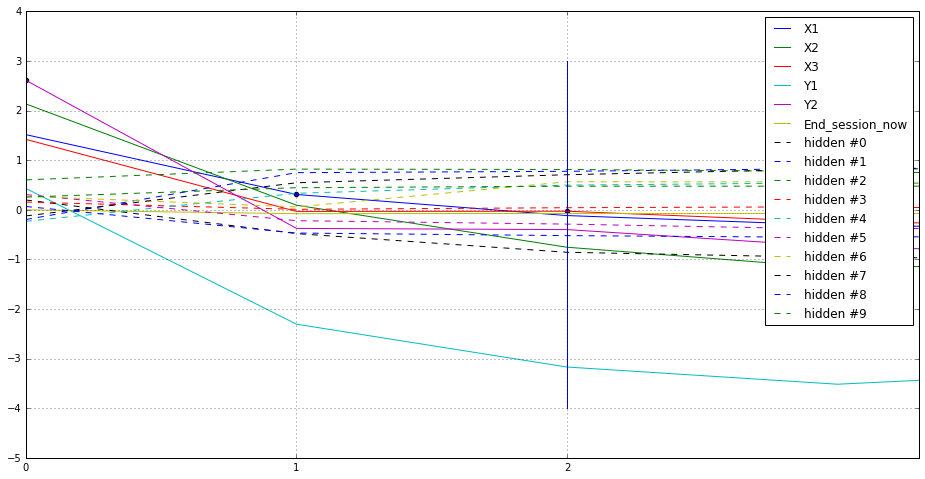

session # 5
 Y2(qv = 2.61072516441) -> 3.0 |  X1(qv = 0.309026807547) -> 1.0 |  X3(qv = -0.0286547541618) -> 1.0 | 



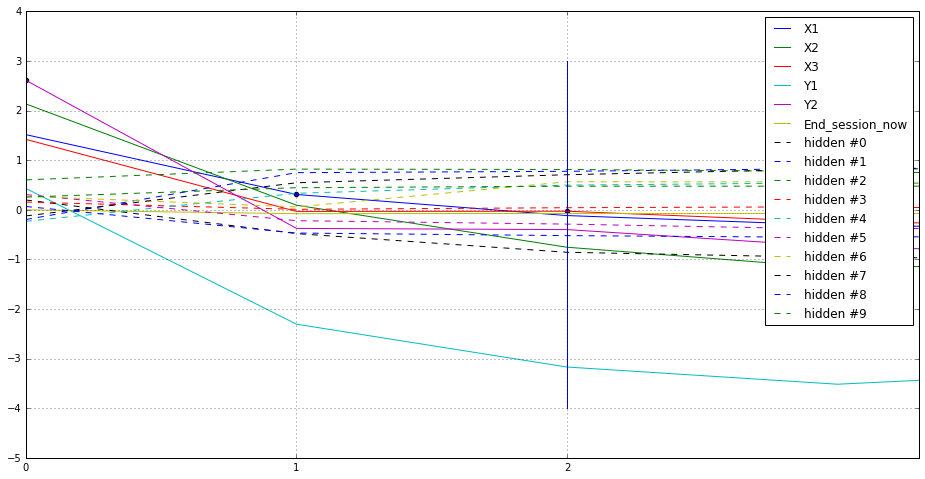

session # 6
 Y2(qv = 2.61072516441) -> 3.0 |  X1(qv = 0.309026807547) -> -1.0 |  X3(qv = 0.0662711262703) -> -1.0 | 



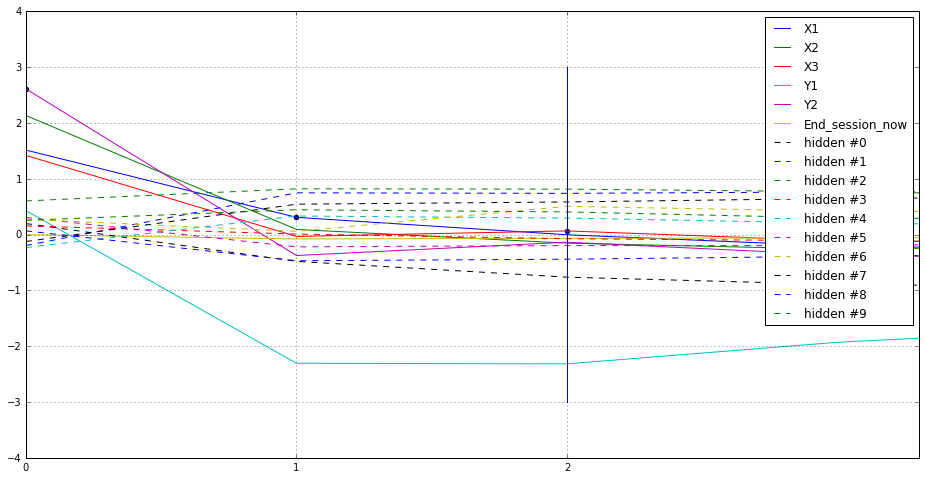

session # 7
 Y2(qv = 2.61072516441) -> 3.0 |  X1(qv = 0.309026807547) -> 1.0 |  X3(qv = -0.0286547541618) -> 1.0 | 



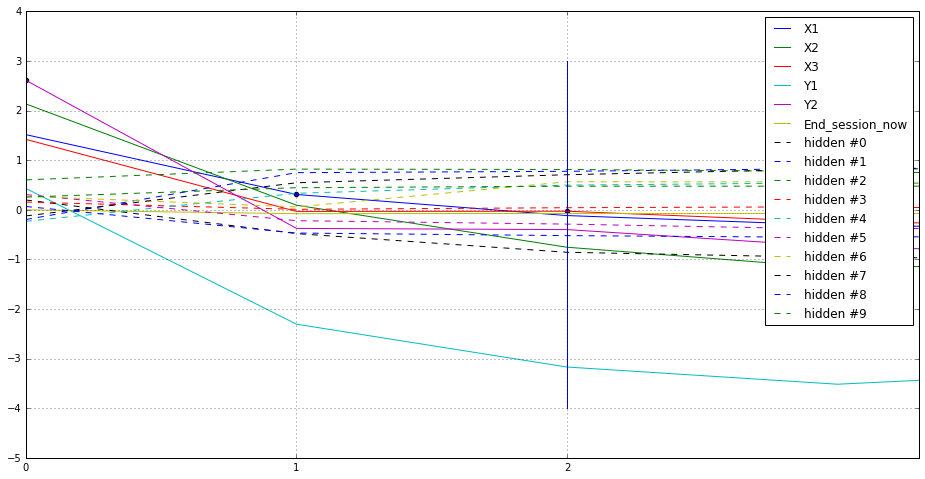

session # 8
 Y2(qv = 2.61072516441) -> -3.0 |  X2(qv = 3.76779222488) -> 1.0 |  Y1(qv = 2.99306082726) -> 3.0 | 



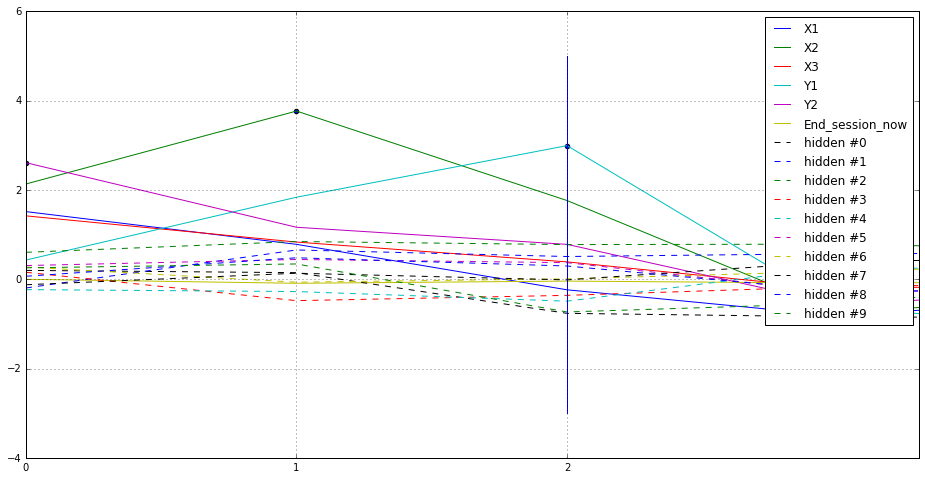

session # 9
 Y2(qv = 2.61072516441) -> 3.0 |  X1(qv = 0.309026747942) -> 1.0 |  X3(qv = -0.0286547541618) -> -1.0 | 



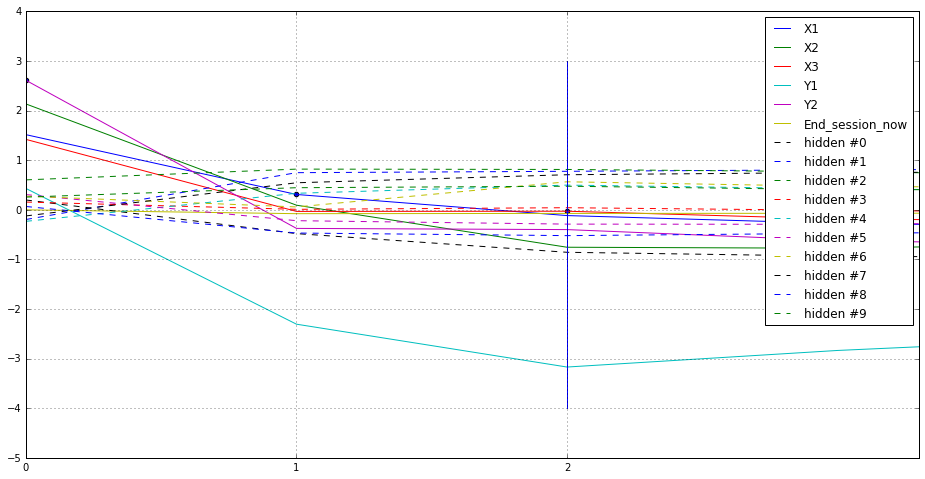

In [21]:
resolver.epsilon.set_value(np.float32(0.))
print "Random session examples"
env.generate_new_data_batch(10)
display_sessions(with_plots=True)
